# Anomaly Detection in Household Power Consumption 

## 1. Introduction
I'm doing this project as practice for machine learning algorithms using time series data. In this notebook, I won't be using the data to predict future values but instead I'm building a model that can identify unusual or abnormal patterns by itself with no labels needed (unsupervised). Anomaly detection is important in the places such as smart homes, utilities, or factories because it can help catch broken appliances, sudden surges/outages, and energy leaks or misuse. 

## 2. Problem Definition
> **Goal**: Can I build a model that learns what ‘normal’ energy behavior looks like across multiple features — and then flags timestamps when things behave strangely?


## 3. Data
This [dataset]("https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption") is from the UC Irvine Machine Learning Repository Website. It measures electric power consumption in one household over one-minute increments over a period of almost 4 years. More specifically, this dataset contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). Also when I downloaded this file from the website, it turned out to be a .txt file so I need to convert it to a csv file in the first few steps.

| Column Name           | Description |
|-----------------------|-------------|
| datetime                  | Date in format dd/mm/yyyy |
| Time                  | Time in format hh:mm:ss |
| Global_active_power   | Household global minute-averaged active power (in kilowatts) |
| Global_reactive_power | Household global minute-averaged reactive power (in kilowatts) |
| Voltage               | Average voltage (in volts) |
| Global_intensity      | Average current intensity (in amperes) |
| Sub_metering_1        | Energy (in watt-hours) sub-metered in the kitchen (e.g., dishwasher, oven, microwave) |
| Sub_metering_2        | Energy (in watt-hours) sub-metered in the laundry room (e.g., washing machine, dryer, refrigerator) |
| Sub_metering_3        | Energy (in watt-hours) sub-metered for electric water heater and air conditioning |

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Load data 
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values='?',
    low_memory=False
)

# Combine 'Date' and 'Time' into a proper datetime column manually
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.drop(columns=['Date', 'Time'], inplace=True)

# Set the datetime as index
df.set_index('datetime', inplace=True)

# Convert all remaining columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Downsample to hourly frequency with updated syntax
df = df.resample('1h').mean().ffill()

# Preview data
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


## 4. Exploratory Data Analysis

In [8]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

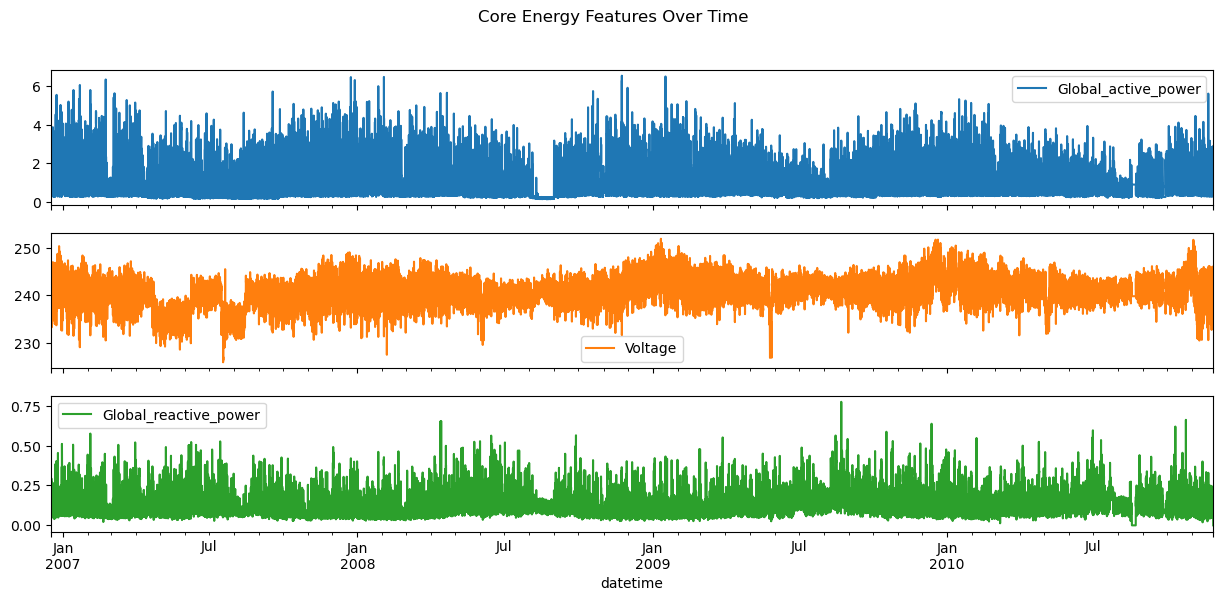

In [13]:
df[['Global_active_power', 'Voltage', 'Global_reactive_power']].plot(figsize=(15, 6), subplots=True)
plt.suptitle('Core Energy Features Over Time')
plt.show()

Looking at this time series plot, several interesting patterns and anomalies emerge:

- Global Active Power:
There are noticeable sudden drops in usage, particularly around August 2008. This could indicate a period of absence (e.g., vacation), a power outage, or potentially sensor failure. The usage also seems to follow daily and seasonal cycles, though less prominently over time.
- Voltage:
The voltage signal shows cyclical patterns, especially from April 2007 to September 2007, with regular up-and-down movements. These may reflect household appliance cycles or grid-level voltage regulation. After 2008, the variation becomes smoother but still retains some seasonality.
- Global Reactive Power:
This series appears more noisy and volatile, but there are still patterns—particularly increased activity during August–September periods each year. These could correlate with higher appliance usage or environmental changes (e.g., HVAC usage in summer months).

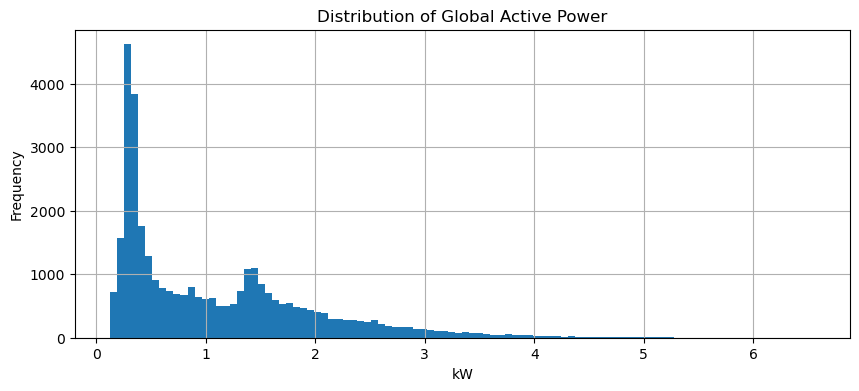

In [16]:
df['Global_active_power'].hist(bins=100, figsize=(10,4))
plt.title("Distribution of Global Active Power")
plt.xlabel("kW")
plt.ylabel("Frequency")
plt.show()

- The histogram shows that most of the household's energy usage is under 1 kW, with a long right tail.
- This indicates a right-skewed distribution, which is typical for residential energy usage — many low-usage periods and a few high-usage spikes.
- These spikes may represent heavy appliance usage, and are potential candidates for anomalies when they occur outside typical patterns.

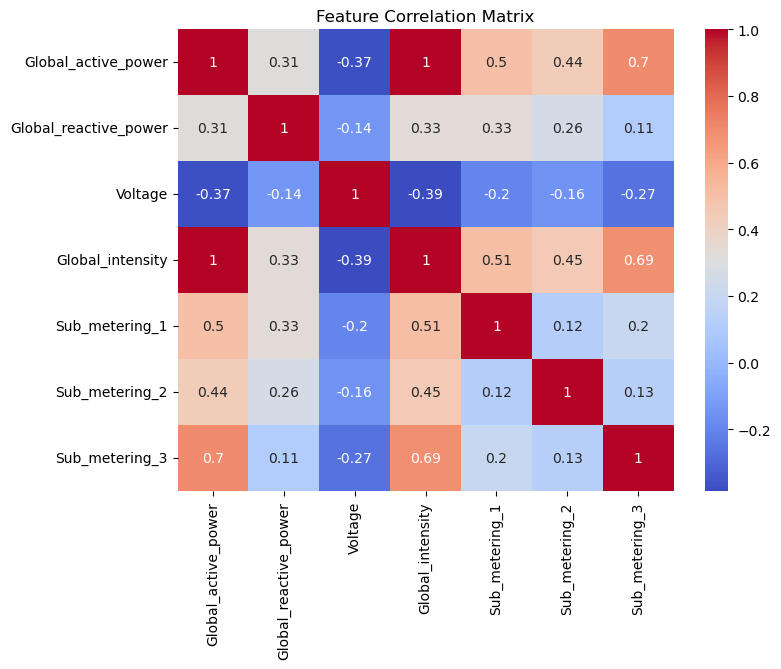

In [17]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

- Global_active_power is strongly correlated with Sub_metering_3 (0.70) and Global_intensity (1.00). This suggests that a large portion of energy usage comes from major appliances (like water heaters and HVAC) and scales directly with current intensity.
- Sub_metering_1 and Sub_metering_2 are moderately correlated with Global_active_power, implying smaller but still notable contributions (e.g., kitchen, laundry room).
- Voltage shows a negative correlation with most features, particularly Global_intensity (-0.39). This might reflect the inverse relationship between voltage and current in load scenarios.

In [25]:
## 5. Apply Isolation Forest
from sklearn.preprocessing import StandardScaler

features = ['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
from sklearn.ensemble import IsolationForest

# Train the model
model = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = model.fit_predict(X_scaled)

# Mark anomalies (score = -1 means anomaly)
df['is_anomaly'] = df['anomaly_score'] == -1

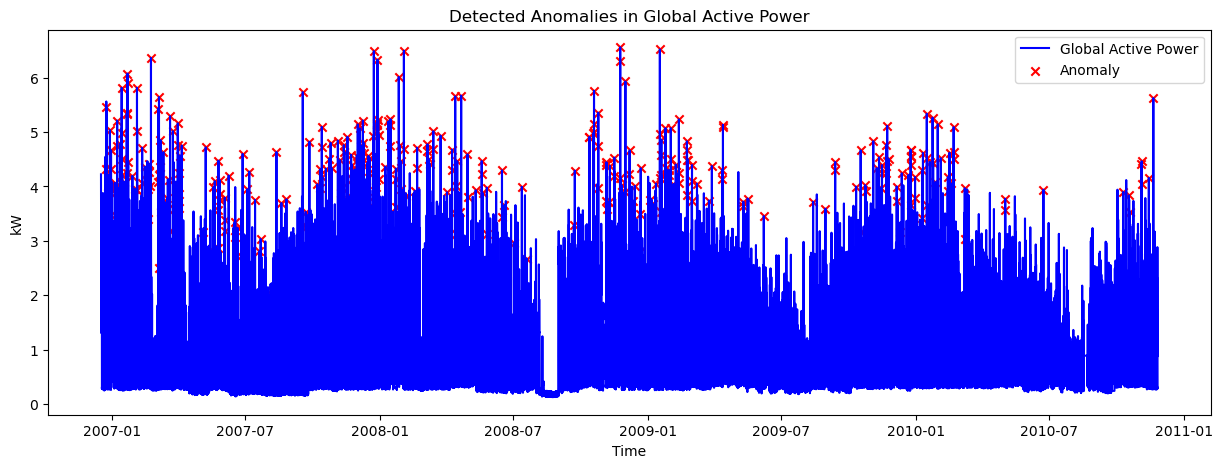

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power', color='blue')
plt.scatter(df[df['is_anomaly']].index,
            df[df['is_anomaly']]['Global_active_power'],
            color='red', label='Anomaly', marker='x')
plt.legend()
plt.title('Detected Anomalies in Global Active Power')
plt.xlabel('Time')
plt.ylabel('kW')
plt.show()

### Interpretation of Anomaly Detection Results

The plot above shows the output of an Isolation Forest model applied to hourly household energy usage data. Red "X" markers indicate timestamps flagged as anomalies based on multivariate patterns.

Most of the anomalies correspond to:
- **Unusually high spikes** in Global Active Power — likely caused by simultaneous use of heavy appliances.
- **Low-usage periods** (e.g., mid-2008), potentially indicating a **vacation, outage, or appliance disconnection**.

The model does a good job of identifying rare behavior based on both magnitude and pattern deviations across multiple features. This supports the project goal: building a model that learns "normal" energy use and flags unusual patterns without labeled examples.

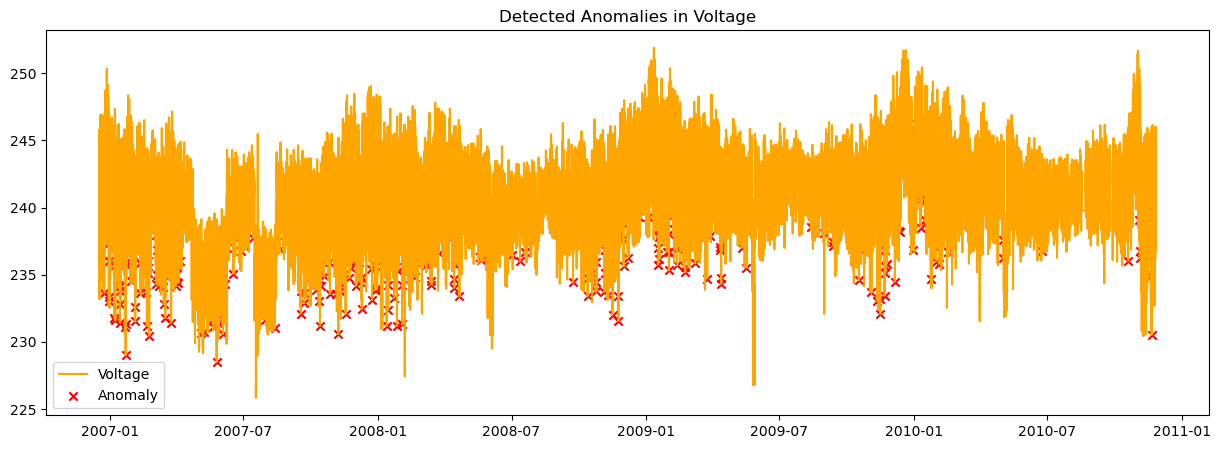

In [29]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['Voltage'], label='Voltage', color='orange')
plt.scatter(df[df['is_anomaly']].index,
            df[df['is_anomaly']]['Voltage'],
            color='red', label='Anomaly', marker='x')
plt.legend()
plt.title('Detected Anomalies in Voltage')
plt.show()

### Detected Anomalies in Voltage

This plot visualizes the household voltage data alongside timestamps flagged as anomalies by the Isolation Forest model.
Key observations:
- Most anomalies occur when **voltage drops below 235V**, which deviates from the more typical 240–245V range.
- These low-voltage points may correspond to:
  - Grid fluctuations
  - Sudden household load changes (e.g., multiple appliances turning on)
  - Faults in voltage regulation or sensor artifacts
- The anomaly detector identifies these low-voltage events as abnormal compared to the usual voltage trend.
This supports the idea that anomalies are not just about high power usage — they also include **abnormal electrical conditions**, reinforcing the value of a multivariate detection approach.

## Conclusion

In this project, I built an unsupervised machine learning model to detect anomalies in household energy usage, using the UCI Individual Household Electric Power Consumption dataset. The goal was to identify unusual patterns without any labeled data — answering the question:

> “Can I build a model that learns what ‘normal’ energy behavior looks like across multiple features — and then flags timestamps when things behave strangely?”

### Key Findings:
- The **Isolation Forest** model effectively flagged abnormal timestamps based on a multivariate understanding of energy usage patterns.
- Anomalies were most commonly associated with:
  - **High spikes** in Global Active Power (e.g., multiple large appliances used simultaneously)
  - **Sudden drops** or **fluctuations** in Voltage, often falling below the typical operating range
  - **Unusual downtime** (e.g., August 2008), suggesting absence, power outages, or sensor failure

### Takeaways:
- A multivariate approach is crucial — anomalies weren’t always extreme in one feature, but were detected due to odd **combinations of values** (e.g., high power + low sub-metering).
- Visualizing anomalies across multiple features helped uncover **different types of "strangeness"** — not just usage spikes, but system-level irregularities too.

### Next Steps:
- Try a **deep learning approach** like an autoencoder to detect anomalies based on reconstruction error.
- Build a **simple dashboard** (e.g., with Streamlit) to explore anomalies interactively.
- Extend to real-time streaming data for predictive energy monitoring.

This project successfully demonstrates how unsupervised models can surface hidden patterns and potential issues in energy consumption data — without relying on labeled anomalies.
